## Summary of the main results

Here is a summary of the main results:
- This is a multicalss classification problem with heavily imbalanced data.
- The __general performance__ of the classifier is often very good when measured with _"accuracy"_ (>90%). This is because the portion of data from price category 0 and 1 is about 93% of the whole. 
- The __micro performance__ considers the classifier's performance for each price category, and is therefore often bad. The essential reason is the lack of data for the minority price categories:
    - category 2 (3.28%), category 5 (1.37%), category 3 (1.29%), category 4 (0.69%).
- Different approaches have been tried to improve the classifier's __micro performance__, but with no significant performance improvement:
    1. applying non-linear scaling of attributes and adding POI attributes,
    2. using 2 heuristic methods, namely one-vs-rest and one-vs-one, together with different binary and multiclass classifiers,
    3. performing random down sampling to the majority category, and SMOTE over sampling to the minority data.
- Merging category 3, 4, and 5 into category 2 improves the __micro performance__ (measured by _"balanced accuracy"_ and _"f1 macro_"). As a result, the classifier can only handle 3 categories: 0, 1, and 2.

For details please refer to the following analysis.

## Import the libraries and load the data

In [1]:
# Import libraries
import pandas as pd
from pandas import set_option
import numpy as np

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

#plot map
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as cx

from math import sqrt, pow, radians, asin, sin, cos, atan2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

import sklearn.metrics

#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
# do not change for reproducibility
np.random.seed(42)

In [3]:
## load data
data = pd.read_csv('data.csv')

## Helper functions

In [4]:
## helper functions

def map_plot(geo_df):
    f,ax = plt.subplots(1,1, figsize=(10, 10))
    geo_df.plot(linewidth=.25, ax=ax, alpha=.5, c=geo_df.color_class) 
    cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, crs=geo_df.crs)

def display_data_portion(data):
    '''
    Display the portions of different price categories in data
    '''
    print(data['price_category'].value_counts())
    price_cate_percent_series = data['price_category'].value_counts()/data['price_category'].count() * 100
    print('\nPrice category percentage:')
    print(price_cate_percent_series)
    data['price_category'].value_counts().plot.pie()

def print_cv_scores(scores):
    '''
    display the scores with mean and standard deviation
    '''
    
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
def perform_cross_validations(classifier, X_train, y_train):
    '''
    Use 10-fold cross validation to evaluate the model's performance
    Four types of performance metrics are used:
        1. accuracy
        2. balanced accuracy
        3. macro f1 score
        4. weighted f1 score
    '''
    accuracy_scores_sub = cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=10)
    balanced_accuracy_scores_sub = cross_val_score(classifier, X_train, y_train, scoring='balanced_accuracy', cv=10)
    f1_macro_scores_sub = cross_val_score(classifier, X_train, y_train, scoring='f1_macro', cv=10)
    f1_weighted_scores_sub = cross_val_score(classifier, X_train, y_train, scoring='f1_weighted', cv=10)
    
    score_dict = {
        'accuracy_mean': [accuracy_scores_sub.mean()],
        'accuracy_std': [accuracy_scores_sub.std()],
        'balanced_accuracy_mean': [balanced_accuracy_scores_sub.mean()],
        'balanced_accuracy_std': [balanced_accuracy_scores_sub.std()],
        'f1_macro_mean': [f1_macro_scores_sub.mean()],
        'f1_macro_std': [f1_macro_scores_sub.std()],
        'f1_weighted_mean': [f1_weighted_scores_sub.mean()],
        'f1_weighted_std': [f1_weighted_scores_sub.std()]
    }
    
    score_df = pd.DataFrame.from_dict(score_dict)
    
    print('\nCross validation: accuracy')
    print_cv_scores(accuracy_scores_sub)
    
    print('\nCross validation: balanced_accuracy')
    print_cv_scores(balanced_accuracy_scores_sub)
    
    print('\nCross validation: f1_macro')
    print_cv_scores(f1_macro_scores_sub)
    
    print('\nCross validation: f1_weighted')
    print_cv_scores(f1_weighted_scores_sub)
    
    return score_df
    
def diaply_cv_scores(score_df):
    '''
    Display the cross validation scores
    '''
    f = plt.figure()
    score_df.rename(index={0:"original_score"}, inplace=True)
    score_df[["accuracy_mean", 
              "balanced_accuracy_mean", 
              "f1_macro_mean", 
              "f1_weighted_mean"]].plot(kind="bar",yerr=score_df[["accuracy_std", 
                                                                  "balanced_accuracy_std", 
                                                                  "f1_macro_std",
                                                                  "f1_weighted_std"]].values.T)
    plt.xticks(rotation= 0, ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.88))
    plt.show()

def evaluate_with_test_data(y_predict, y_test):
    '''
    Evaluate the prediction performance with test data.
    Four performance metrics are used:
        1. accuracy
        2. balanced accuracy
        3. macro f1 score
        4. weighted f1 score
    '''
    
    accuracy_scores_sub = sklearn.metrics.accuracy_score(y_predict, y_test)
    balanced_accuracy_scores_sub = sklearn.metrics.balanced_accuracy_score(y_predict, y_test)
    f1_macro_scores_sub = sklearn.metrics.f1_score(y_predict, y_test, average='macro')
    f1_weighted_scores_sub = sklearn.metrics.f1_score(y_predict, y_test, average='weighted')
    
    print(f'\nAccuracy: {accuracy_scores_sub:.3f}')
    
    print(f'\nBalanced accuracy: {balanced_accuracy_scores_sub:.3f}')
    
    print(f'\nF1_macro: {f1_macro_scores_sub:.3f}')
    
    print(f'\nF1_weighted: {f1_weighted_scores_sub:.3f}')
    
def train_and_evaluate_ovr(model, feature_df, target_df):
    '''
    Use One-Vs-Rest to handle multiclass classification
    '''
    ovr = OneVsRestClassifier(model)

    ovr.fit(feature_df, target_df)
    ovr_predictions = ovr.predict(feature_test)

    evaluate_with_test_data(ovr_predictions, target_test)
    
    ## Confusion matrix

    cm = sklearn.metrics.confusion_matrix(target_test, ovr_predictions, labels=ovr.classes_)
    plt.figure(figsize = (7, 5))
    sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')
    
def train_and_evaluate_ovo(model, feature_df, target_df):
    '''
    Use One-Vs-One to handle multiclass classification
    '''
    ovo = OneVsOneClassifier(model)

    ovo.fit(feature_df, target_df)
    ovo_predictions = ovo.predict(feature_test)

    evaluate_with_test_data(ovo_predictions, target_test)
    
    ## Confusion matrix

    cm = sklearn.metrics.confusion_matrix(target_test, ovo_predictions, labels=ovo.classes_)
    plt.figure(figsize = (7, 5))
    sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

## Data exploration

In [5]:
## Print the data
data_print = data.drop(['latitude', 'longitude'], axis=1)
data_print.head()

,Unnamed: 0,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,price_category
0,0,brick,1,5.0,18.0,3.0,0
1,1,brick,1,5.0,15.0,3.0,0
2,2,brick,1,5.0,11.9,1.5,0
3,3,brick,1,7.0,18.4,3.0,0
4,4,brick,2,5.0,17.6,2.0,0


In [6]:
## Drop the column 'Unnamed: 0'

data = data.drop(columns=['Unnamed: 0'])

In [7]:
## Make a copy of the original data, and generate data_geodf
data_copy = data.copy()
data_geodf = gpd.GeoDataFrame(data_copy, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=4326) 

In [8]:
col = 'price_category'
conditions = [data_geodf[col] == 0, data_geodf[col] == 1, data_geodf[col] == 2, data_geodf[col] == 3, data_geodf[col] == 4, data_geodf[col] == 5]
colors  = [ "midnightblue", 'dodgerblue','magenta', 'darksalmon', 'darkgreen', 'orangered']
data_geodf["color_class"] = np.select(conditions, colors, default=np.nan)

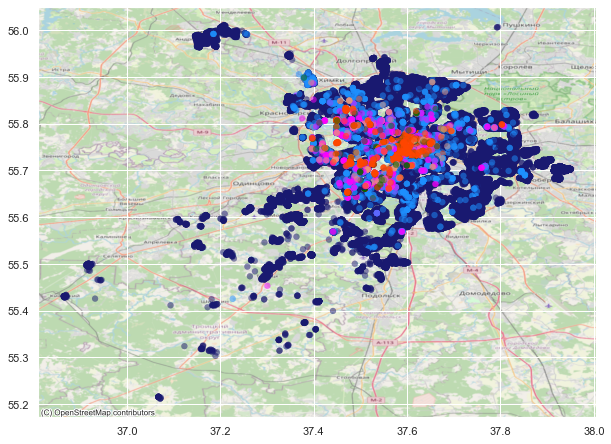

In [9]:
#### Scatter map for all different price categories
map_plot(data_geodf)

In [10]:
# price category 0
#data_geodf_0 = data_geodf[data_geodf.price_category== 0]
#map_plot(data_geodf_0)

In [11]:
# price category 4
#data_geodf_1 = data_geodf[data_geodf.price_category== 4]
#map_plot(data_geodf_1)

In [12]:
# price category 5
#data_geodf_2 = data_geodf[data_geodf.price_category== 5]
#map_plot(data_geodf_2)

In [13]:
## Overview of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wallsMaterial   63945 non-null  object 
 1   floorNumber     63945 non-null  int64  
 2   floorsTotal     63945 non-null  float64
 3   totalArea       63945 non-null  float64
 4   kitchenArea     63945 non-null  float64
 5   latitude        63945 non-null  float64
 6   longitude       63945 non-null  float64
 7   price_category  63945 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 3.9+ MB


0    51131
1     8573
2     2100
5      879
3      823
4      439
Name: price_category, dtype: int64

Price category percentage:
0    79.960904
1    13.406834
2     3.284072
5     1.374619
3     1.287044
4     0.686527
Name: price_category, dtype: float64


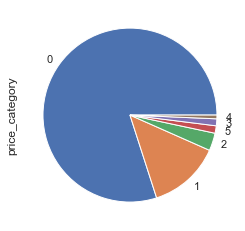

In [14]:
## Portion of the price categories in the whole dataset

display_data_portion(data)

In [15]:
## Check NULL and NA in the data

print('\nDoes data have null?\n', data.isnull().sum())
print('\nDoes data have NA?\n', data.isna().sum())


Does data have null?
 wallsMaterial     0
floorNumber       0
floorsTotal       0
totalArea         0
kitchenArea       0
latitude          0
longitude         0
price_category    0
dtype: int64

Does data have NA?
 wallsMaterial     0
floorNumber       0
floorsTotal       0
totalArea         0
kitchenArea       0
latitude          0
longitude         0
price_category    0
dtype: int64


In [16]:
## Check unique values

data.wallsMaterial.unique()

array(['brick', 'monolithBrick', 'panel', 'block', 'monolith', 'stalin',
       'wood', 'old', 'None'], dtype=object)

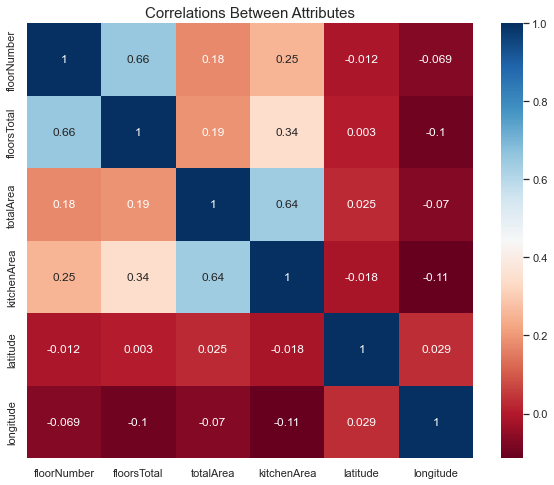

In [17]:
## Correlations between different attributes
plt.figure(figsize=(10,8))
sns.heatmap(data.drop(columns=['price_category']).corr(), annot=True, cmap="RdBu")
plt.title("Correlations Between Attributes", size=15)
plt.show()

__Observations:__

1. 'floorsTotal' and 'floorNumber' have good correlation
2. 'kitchenArea' and 'totalArea' have good correlation

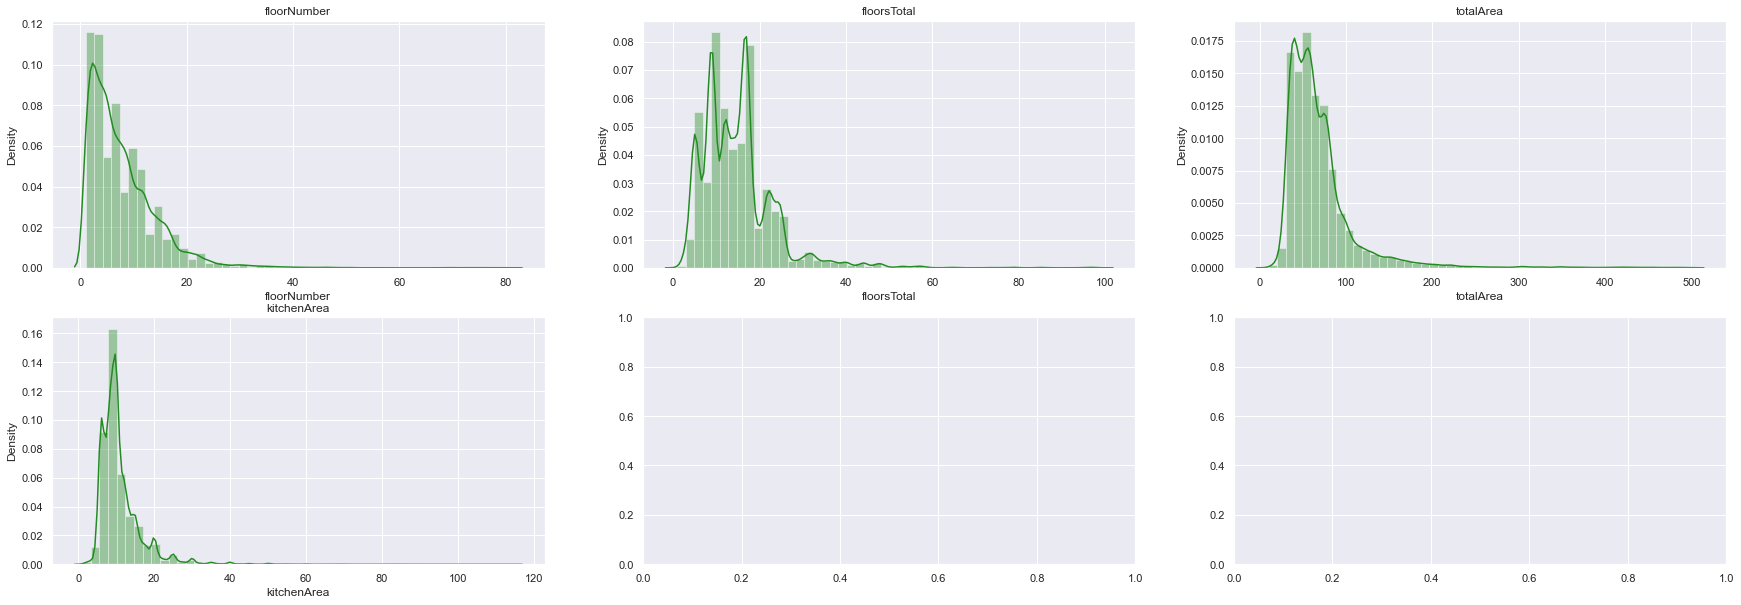

In [18]:
## Check the distribution of the numerical columns

num_cols = ['floorNumber', 'floorsTotal', 'totalArea', 'kitchenArea']

fig, axes = plt.subplots(nrows = 2, ncols = 3)
axes = axes.flatten()
fig.set_size_inches(30, 10)

for ax, col in zip(axes, num_cols):
  sns.distplot(data[col], ax = ax, color='forestgreen')
  ax.set_title(col)

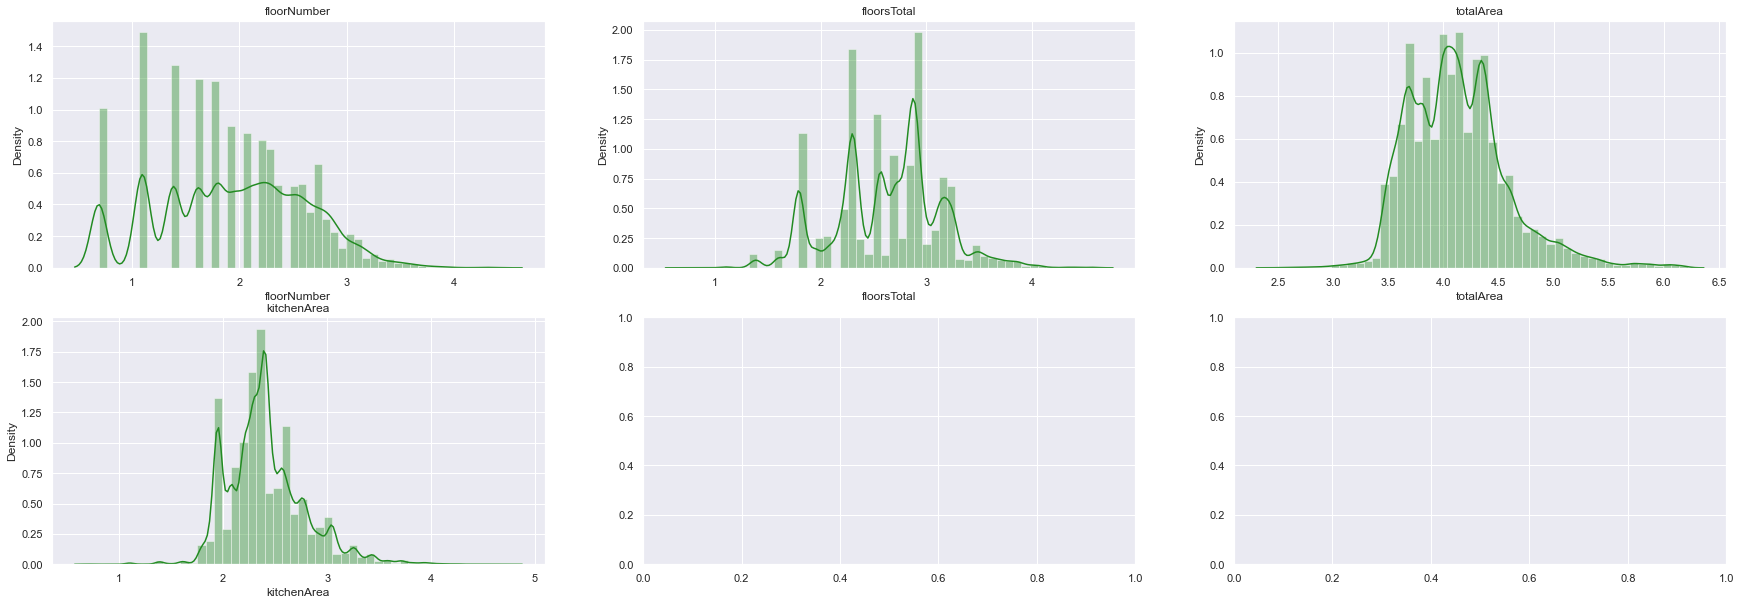

In [19]:
## Check the distribution after a non-linear scaling

fig, axes = plt.subplots(nrows = 2, ncols = 3)
axes = axes.flatten()
fig.set_size_inches(30, 10)

for ax, col in zip(axes, num_cols):
  sns.distplot(np.log1p(data[col]), ax = ax, color='forestgreen')
  ax.set_title(col)

__Note:__

The numerical columns are skewed, and applying log scaling reduces the skewness. Therefore log scaling is used in the data preprocessing (see the code below)

## Data preprocessing

Data preprocessing has 4 steps:
- Step 1: adding points of interest (POIs)
    
    Based on the GPS information, POIs can be added to facilitate the classification. In this work the following 2 POIs are used:
    1. Red square, the city center of Moscow
    2. Moscow International Business Center (MIBC)
    For each record, distances to these 2 POIs are computed. Other POIs could also be added later, such as schools, bus stops, subway stations, restaurants, etc. 
    
- Step 2: applying one-hot encoding to the categorical attribute
- Step 3: applying non-linear scaling to the numerical attributes (explained above)
- Step 4: marging categories 3, 4, and 5 into category 2

#### Preprocess step 1: POI

In [20]:
# POI

POI_data = {'poi_name': ['red_square', 'MIBC'],
            'latitude': [55.7538840977827, 55.749200506947986],
            'longitude': [37.620755645384904, 37.54016137558259]    
        }
POI_df = pd.DataFrame(POI_data)

In [21]:
POI_df

,poi_name,latitude,longitude
0,red_square,55.753884,37.620756
1,MIBC,55.749201,37.540161


In [22]:
EARTH_RADIUS_METERS = 6378137 # (mean) radius of Earth (meters)
def squared(x):
    return x * x
def haversineDist(aLat, aLng, bLat, bLng):
    """haversine distance - arc length between two points on a sphere
    """
    dLat = radians(bLat - aLat);
    dLon = radians(bLng - aLng);
    f = squared(sin(dLat / 2.0)) + cos(radians(aLat)) * cos(radians(bLat)) * squared(sin(dLon / 2.0))
    c = 2 * atan2(sqrt(f), sqrt(1 - f))
    return c * EARTH_RADIUS_METERS/1000

In [23]:
for item in range(0, len(POI_df)):
    data[POI_df.poi_name[item] + '_distance'] = data.apply(lambda x: haversineDist(x.latitude, 
                                                                                    x.longitude, 
                                                                                    POI_df.latitude[item],
                                                                                    POI_df.longitude[item]), axis=1)

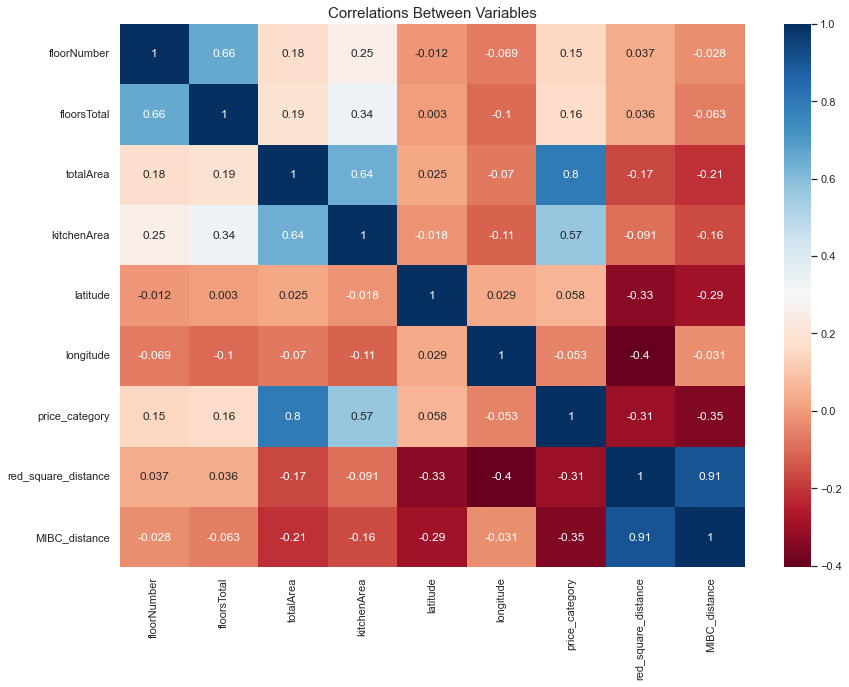

In [24]:
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(), annot=True, cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

#### Preprocess step 2: one-hot encoding

Because the attribute "wallsMaterial" is categorical data, so I use one-hot encoding to process it.

In [25]:
## 1-hop encoding for 'wallsMaterial'

wall_data = data.wallsMaterial
wall_data_1hot = pd.get_dummies(wall_data, prefix='wall')

data_new = pd.concat([wall_data_1hot, data], axis=1, join='inner')

## drop column 'wallsMaterial'
data_new = data_new.drop(columns=['wallsMaterial'])

In [26]:
data_new.columns

Index(['wall_None', 'wall_block', 'wall_brick', 'wall_monolith',
       'wall_monolithBrick', 'wall_old', 'wall_panel', 'wall_stalin',
       'wall_wood', 'floorNumber', 'floorsTotal', 'totalArea', 'kitchenArea',
       'latitude', 'longitude', 'price_category', 'red_square_distance',
       'MIBC_distance'],
      dtype='object')

#### Preprocess step 3: non-linear scaling

In [27]:
log_cols = ['floorNumber', 'floorsTotal', 'totalArea', 'kitchenArea', 'red_square_distance', 'MIBC_distance']

data_new[log_cols] = np.log1p(data[log_cols])

#### Preprocess step 4: merge categories 3, 4, 5 into category 2

In [28]:
## Merge category 2-5 as a single category 2

data_new['price_category_new'] = data_new['price_category'].apply(lambda x: 2 if x>2 else x)
data_new.drop(columns=['price_category'], inplace=True)

data_new.rename(columns={'price_category_new':'price_category'}, inplace=True)

0    51131
1     8573
2     4241
Name: price_category, dtype: int64

Price category percentage:
0    79.960904
1    13.406834
2     6.632262
Name: price_category, dtype: float64


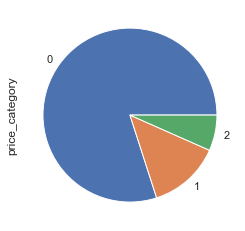

In [29]:
display_data_portion(data_new)

## Split the data for training and testing

In [30]:
## Split the data for training and testing (last 10000 records)

test_size = 10000
train_size = len(data_new) - test_size

target = data_new['price_category'].to_frame()
feature = data_new.drop(columns=['price_category'])

feature_train = feature[0:train_size]
feature_test = feature[train_size:len(data)]

target_train = target[0:train_size]
target_test = target[train_size:len(data)]

## Summary of the analysis

Here is a summary of the performance of different models:

- Random forest gives very good performance, especially in terms of the general performance.
- About one-vs-rest and one-vs-one:
    - They enable binary classifiers, such as logistic regression and SVM, to perform multiclass classification. But the performance is __not__ convincing. 
    - Using them together with random forest does improve the performance a bit further.
- About under sampling and over sampling/SMOTE:
    - Creating balanced data set does __not__ improve the performance as expected.
    - Instead, __over sampling/SMOTE might overfit__ the classifier for the minority categories and result in poorer performance. This is especially the case when the minority categories have very few samples.

## With imbalanced data

The following models are created and evaluated with imbalance data:
- Baseline model with random forest
- One-Vs-Rest with Logistic Regression
- One-Vs-Rest with Random Forest
- One-Vs-One with SVM
- One-Vs-One with Random Forest

#### Baseline model - random forest with imbalanced data

In [31]:
## Ramdom forest classifier

# forest_clf = RandomForestClassifier(class_weight='balanced')
forest_clf = RandomForestClassifier()
# forest_clf = BalancedRandomForestClassifier()
# forest_clf = EasyEnsembleClassifier()

In [32]:
%%time
## Cross validation with different parameters 

original_score_df = perform_cross_validations(forest_clf, feature_train, target_train)


Cross validation: accuracy
Scores: [0.95866543 0.93790547 0.95773865 0.95069509 0.92381835 0.91268076
 0.93566926 0.94938821 0.94642195 0.94011865]
Mean: 0.9413101812572442
Standard deviation: 0.013860015409667952

Cross validation: balanced_accuracy
Scores: [0.8959085  0.85744318 0.89951856 0.87079222 0.81622138 0.74578414
 0.89432863 0.90440957 0.83018753 0.8414201 ]
Mean: 0.8556013802761907
Standard deviation: 0.04703951394198497

Cross validation: f1_macro
Scores: [0.90663943 0.86450707 0.90672655 0.88595081 0.84007334 0.78597968
 0.86795548 0.89839923 0.87203069 0.85535012]
Mean: 0.8683612398778638
Standard deviation: 0.0345448858152524

Cross validation: f1_weighted
Scores: [0.95907615 0.93909678 0.95605059 0.95023116 0.92581731 0.91307908
 0.9395202  0.94640723 0.94605452 0.94036312]
Mean: 0.9415696138154453
Standard deviation: 0.0130626674379431
Wall time: 2min 41s


<Figure size 432x288 with 0 Axes>

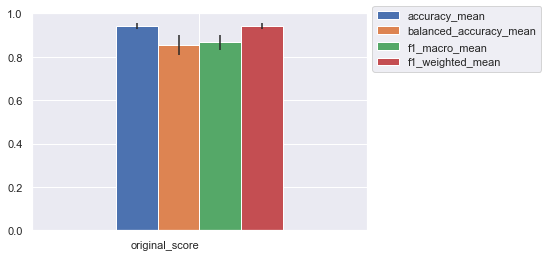

In [33]:
## Plot the corss validation scores

diaply_cv_scores(original_score_df)

In [34]:
%%time
## Train the random forest classifier with imbalanded data

forest_clf.fit(feature_train, target_train)
training_predictions = forest_clf.predict(feature_test)

evaluate_with_test_data(training_predictions, target_test)


Accuracy: 0.943

Balanced accuracy: 0.888

F1_macro: 0.880

F1_weighted: 0.944
Wall time: 4.51 s


In [35]:
## Display the parameters of forest_clf

forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
## Display the probabilities of each prediction

training_predictions_proba = forest_clf.predict_proba(feature_test)
training_predictions_proba

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.99, 0.01, 0.  ],
       ...,
       [0.73, 0.2 , 0.07],
       [0.69, 0.2 , 0.11],
       [0.64, 0.23, 0.13]])

<AxesSubplot:>

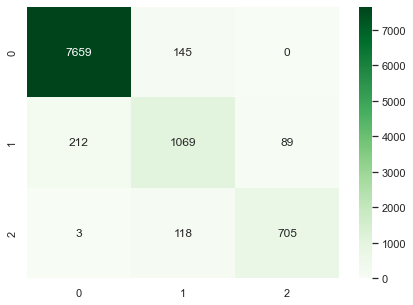

In [37]:
## Confusion matrix

cm = sklearn.metrics.confusion_matrix(target_test, training_predictions, labels=forest_clf.classes_)
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

#### Model 1: One-Vs-Rest with Logistic Regression


Accuracy: 0.891

Balanced accuracy: 0.812

F1_macro: 0.756

F1_weighted: 0.901


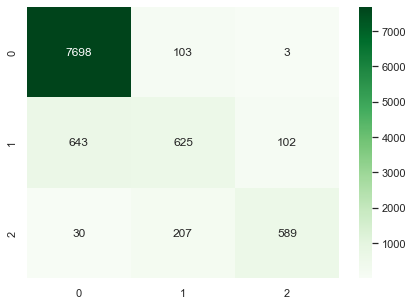

In [38]:
lr_clf = LogisticRegression()

# lr_clf.fit(feature_train, target_train)
# lr_predictions = lr_clf.predict(feature_test)
# evaluate_with_test_data(lr_predictions, target_test)

## define and evaluate one-vs-rest classifier
train_and_evaluate_ovr(lr_clf, feature_train, target_train)

In [39]:
## Display the parameters of forest_clf

forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [40]:
## Display the probabilities of each prediction

training_predictions_proba = forest_clf.predict_proba(feature_test)
training_predictions_proba

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.99, 0.01, 0.  ],
       ...,
       [0.73, 0.2 , 0.07],
       [0.69, 0.2 , 0.11],
       [0.64, 0.23, 0.13]])

#### Model 2: One-Vs-Rest with Random Forest


Accuracy: 0.946

Balanced accuracy: 0.892

F1_macro: 0.885

F1_weighted: 0.946


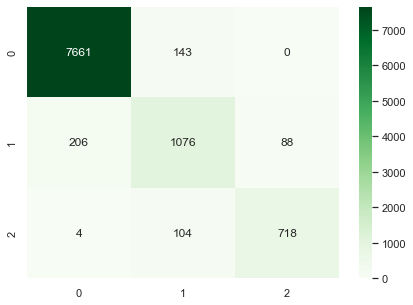

In [41]:
rf_clf = RandomForestClassifier()

## define and evaluate one-vs-rest classifier
train_and_evaluate_ovr(rf_clf, feature_train, target_train)

#### Model 3: One-Vs-One with SVM


Accuracy: 0.823

Balanced accuracy: 0.738

F1_macro: 0.486

F1_weighted: 0.860
Wall time: 1min 46s


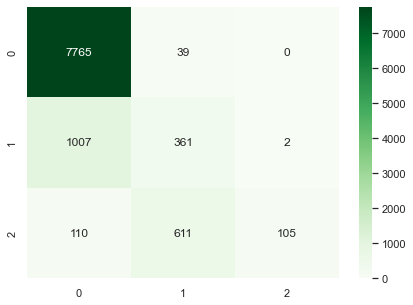

In [42]:
%%time
## define SVM classifier
svc_clf = SVC()

## define and evaluate one-vs-one classifier
train_and_evaluate_ovo(svc_clf, feature_train, target_train)

#### Model 4: One-Vs-One with Random Forest


Accuracy: 0.946

Balanced accuracy: 0.894

F1_macro: 0.886

F1_weighted: 0.946


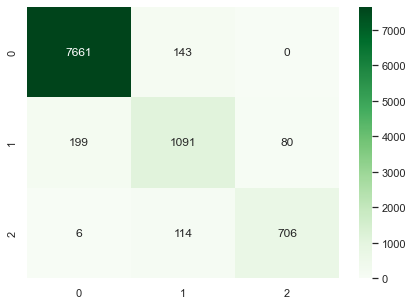

In [43]:
rf_clf = RandomForestClassifier()

## define and evaluate one-vs-rest classifier
train_and_evaluate_ovo(rf_clf, feature_train, target_train)

## Balance the data of different classes

1. Step 1: randomly under sample cagetory 0 (to the size of category 1)
2. Step 2: over sample category 2, 3, 4, and 5 using SMOTE

__Note:__

An alternative approach is to skip step1, i.e., without under sampling the majority category, and only over sampling the minority categories to the size of category 0. This did not improve the performance, but slowed down the performance significantly. Therefore I did not include it in this notebook.

0    43327
1     7203
2     3415
Name: price_category, dtype: int64

Price category percentage:
0    80.316990
1    13.352489
2     6.330522
Name: price_category, dtype: float64


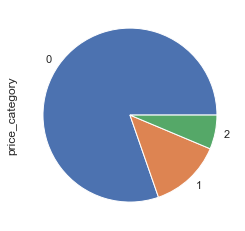

In [44]:
## Portion of the price categories in the training data

display_data_portion(target_train)

In [45]:
## Step 1: randomly understand sample category 0 to the size of category 1
## to avoid other minority categories being too much over sampled

cat_0_train_tgt_df = target_train[target_train['price_category'] == 0]
cat_1_train_tgt_df = target_train[target_train['price_category'] == 1]
cat_non0_train_tgt_df = target_train[target_train['price_category'] != 0]

cat_0_train_tgt_us_df = cat_0_train_tgt_df.sample(len(cat_1_train_tgt_df))

## Get the under sampled target dataframe
us_target_train = pd.concat([cat_0_train_tgt_us_df, cat_non0_train_tgt_df])

## Get the list of indices
us_idx_list = us_target_train.index.values

## Get the under sampled feature dataframe by filtering the feature_train with the list of indices
us_feature_train = feature_train.loc[us_idx_list]

0    7203
1    7203
2    3415
Name: price_category, dtype: int64

Price category percentage:
0    40.418607
1    40.418607
2    19.162785
Name: price_category, dtype: float64


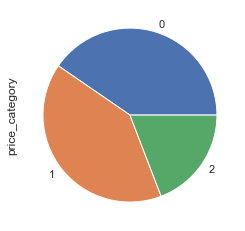

In [46]:
display_data_portion(us_target_train)

In [47]:
## Step 2: over sample using SMOTE

smote = SMOTE()

smote_feature_train, smote_target_train = smote.fit_resample(us_feature_train, us_target_train)

0    7203
1    7203
2    7203
Name: price_category, dtype: int64

Price category percentage:
0    33.333333
1    33.333333
2    33.333333
Name: price_category, dtype: float64


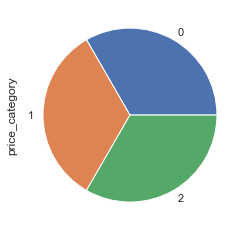

In [48]:
display_data_portion(smote_target_train)

## With balanced data

The following models are created and evaluated with balanced data:
- Random Forest
- One-Vs-Rest with Logistic Regression
- One-Vs-Rest with Random Forest
- One-Vs-One with SVM
- One-Vs-One with Random Forest

#### Model 5: Random Forest with balanced data

In [49]:
## Ramdom forest classifier

balanced_forest_clf = RandomForestClassifier()

In [50]:
%%time
## Cross validation with different parameters 

balanced_score_df = perform_cross_validations(balanced_forest_clf, smote_feature_train, smote_target_train)


Cross validation: accuracy
Scores: [0.90745025 0.90930125 0.87413235 0.91022675 0.86302638 0.92179547
 0.89865803 0.91624248 0.909764   0.9037037 ]
Mean: 0.9014300649562103
Standard deviation: 0.017641014136486794

Cross validation: balanced_accuracy
Scores: [0.90605255 0.90929008 0.8805883  0.90840204 0.86446679 0.91535419
 0.89722993 0.91621655 0.91066163 0.90416667]
Mean: 0.9012428725535522
Standard deviation: 0.015668251981525983

Cross validation: f1_macro
Scores: [0.90370227 0.91485715 0.8779129  0.90829909 0.86498791 0.91767163
 0.8992929  0.91556549 0.90675701 0.90375694]
Mean: 0.9012803296532539
Standard deviation: 0.016172363905309243

Cross validation: f1_weighted
Scores: [0.90694197 0.91397237 0.88088676 0.90599078 0.86634494 0.91922983
 0.89997084 0.92366207 0.90635014 0.9042639 ]
Mean: 0.9027613587965055
Standard deviation: 0.01639884414064362
Wall time: 1min 15s


<Figure size 432x288 with 0 Axes>

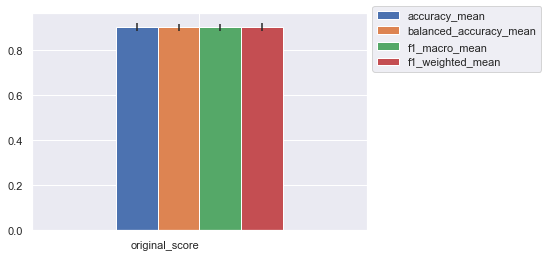

In [51]:
## Plot the corss validation scores

diaply_cv_scores(balanced_score_df)

In [52]:
%%time
## Train the random forest classifier with balanded data

balanced_forest_clf.fit(smote_feature_train, smote_target_train)
balanced_training_predictions = balanced_forest_clf.predict(feature_test)

evaluate_with_test_data(balanced_training_predictions, target_test)


Accuracy: 0.915

Balanced accuracy: 0.833

F1_macro: 0.858

F1_weighted: 0.909
Wall time: 2.32 s


<AxesSubplot:>

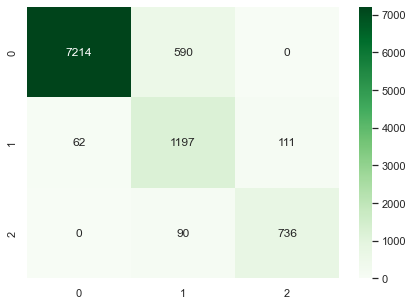

In [53]:
## Confusion matrix

cm = sklearn.metrics.confusion_matrix(target_test, balanced_training_predictions, labels=balanced_forest_clf.classes_)
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

#### Model 6: OVR with Logistic Regression with balanced data


Accuracy: 0.890

Balanced accuracy: 0.767

F1_macro: 0.790

F1_weighted: 0.886


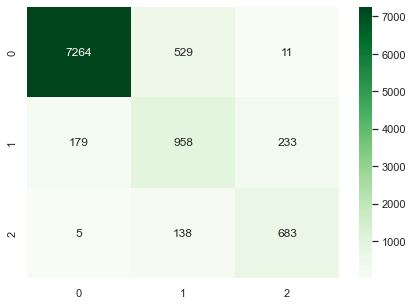

In [54]:
lr_clf = LogisticRegression()

## define and evaluate one-vs-rest classifier
train_and_evaluate_ovr(lr_clf, smote_feature_train, smote_target_train)

#### Model 7: OVR with Random Forest with balanced data


Accuracy: 0.916

Balanced accuracy: 0.834

F1_macro: 0.859

F1_weighted: 0.910


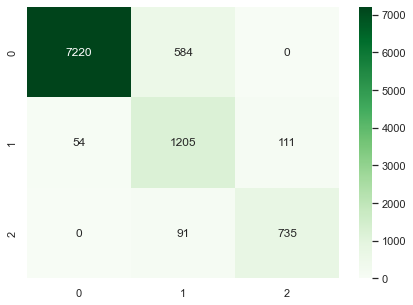

In [55]:
rf_clf = RandomForestClassifier()

## define and evaluate one-vs-rest classifier
train_and_evaluate_ovr(rf_clf, smote_feature_train, smote_target_train)

#### Model 8: OVO with SVM with balanced data


Accuracy: 0.832

Balanced accuracy: 0.768

F1_macro: 0.752

F1_weighted: 0.812


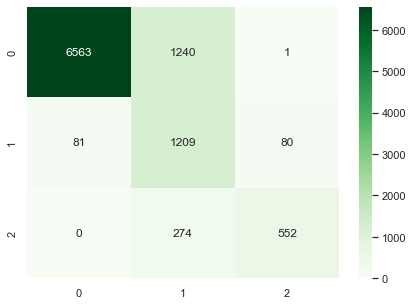

In [56]:
## define SVM classifier
svc_clf = SVC()

## define and evaluate one-vs-one classifier
train_and_evaluate_ovo(svc_clf, smote_feature_train, smote_target_train)

#### Model 9: OVO with Random Forest with balanced data


Accuracy: 0.916

Balanced accuracy: 0.835

F1_macro: 0.860

F1_weighted: 0.910


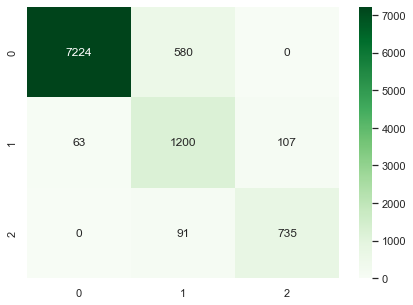

In [57]:
rf_clf = RandomForestClassifier()

## define and evaluate one-vs-rest classifier
train_and_evaluate_ovo(rf_clf, smote_feature_train, smote_target_train)